Solution to a problem posted at

https://www.reddit.com/r/statistics/comments/4d4u8o/complicated_probability_question/


Copyright 2016 Allen Downey

MIT License: http://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

import numpy as np
import scipy

import thinkbayes2
import thinkplot

%matplotlib inline

Roll six 6-sided dice:

In [3]:
a = np.array([122.8, 115.5, 102.5, 84.7, 154.2, 83.7, 122.1, 
              117.6, 98.1, 111.2, 80.3, 110.0, 117.6, 100.3, 107.8, 60.2])
b = np.array([82.6, 99.1, 74.6, 51.9, 62.3, 67.2, 82.4, 97.2, 
              68.9, 77.9, 81.5, 87.4, 92.4, 80.8, 74.7, 42.1])
n = len(a)
n

16

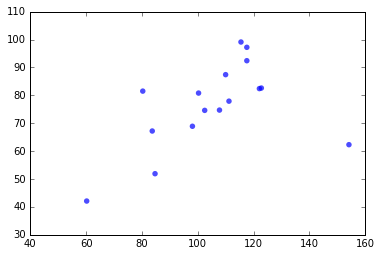

In [70]:
thinkplot.Scatter(a, b, alpha=0.7)

In [4]:
X = np.array([a, b])
X

array([[ 122.8,  115.5,  102.5,   84.7,  154.2,   83.7,  122.1,  117.6,
          98.1,  111.2,   80.3,  110. ,  117.6,  100.3,  107.8,   60.2],
       [  82.6,   99.1,   74.6,   51.9,   62.3,   67.2,   82.4,   97.2,
          68.9,   77.9,   81.5,   87.4,   92.4,   80.8,   74.7,   42.1]])

In [5]:
mean = X.mean(axis=1)
mean

array([ 105.5375,   76.4375])

In [6]:
std = X.std(axis=1)
std

array([ 21.04040384,  14.93640163])

In [7]:
cov = np.cov(X)
cov

array([[ 472.21183333,  161.33583333],
       [ 161.33583333,  237.96916667]])

In [9]:
np.corrcoef(a, b)

array([[ 1.       ,  0.4812847],
       [ 0.4812847,  1.       ]])

Count how many times each outcome occurs and score accordingly:

In [19]:
def std_rho(cov):
    sig1 = np.sqrt(cov[0][0])
    sig2 = np.sqrt(cov[1][1])
    rho = cov[0][1] / sig1 / sig2
    return sig1, sig2, rho

std_rho(cov)

(21.730435645272582, 15.426249274099867, 0.4812847033595688)

In [12]:
def generate(mean, cov, n):
    return np.random.multivariate_normal(mean, cov, n).transpose()

generate(mean, cov, n)

array([[  84.59929985,   89.57176973,  155.61751474,  101.75908304,
          93.90048195,   85.77985658,  101.99786948,   86.13701948,
          99.08807206,  156.19390156,  174.45100675,  117.62255573,
         113.84035678,  135.28096296,   93.95896476,  102.40143794],
       [  95.6810057 ,   86.23965465,   76.26438547,   88.58854004,
          83.67936287,   62.17471619,   74.86347277,   53.19738324,
          78.67735806,   93.10771611,   96.33163607,   95.70108964,
          93.07634711,   86.82267992,   63.7135515 ,   42.82157951]])

In [13]:
def estimate(X):
    return X.mean(axis=1), np.cov(X)

In [14]:
estimate(generate(mean, cov, n))

(array([ 110.3298798 ,   77.36899019]), array([[ 246.23868709,   56.10257952],
        [  56.10257952,  136.61633044]]))

In [15]:
def generate_statistics(mean, cov, n, iters):
    return [estimate(generate(mean, cov, n)) for _ in range(iters)]

stats = generate_statistics(mean, cov, n, 101)

In [61]:
def z_prime(r):
    return 0.5 * np.log((1+r) / (1-r))

def sampling_distributions(stats, cov, n):
    sig1, sig2, _ = std_rho(cov)
    
    array = np.zeros((len(stats), 8))
    for i, (xbar, S) in enumerate(stats):
        array[i, 0:2] = xbar
        s1 = np.sqrt(S[0, 0])
        s2 = np.sqrt(S[1, 1])
        r = S[0][1] / s1 / s2
        array[i, 2] = s1
        array[i, 3] = s2
        array[i, 4] = r
        array[i, 5] = (n-1) * S[0, 0] / cov[0, 0]
        array[i, 6] = (n-1) * S[1, 1] / cov[1, 1]
        array[i, 7] = z_prime(r)
    return array

dists = sampling_distributions(stats, cov, n)

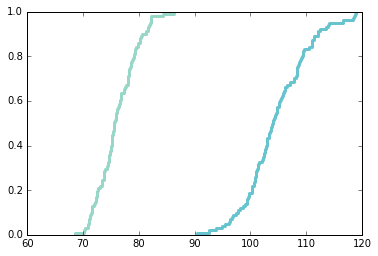

In [62]:
cdf0 = thinkbayes2.Cdf(dists[:, 0])
cdf1 = thinkbayes2.Cdf(dists[:, 1])
thinkplot.Cdfs([cdf0, cdf1])

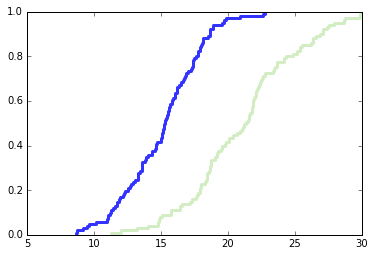

In [55]:
cdf2 = thinkbayes2.Cdf(dists[:, 2])
cdf3 = thinkbayes2.Cdf(dists[:, 3])
thinkplot.Cdfs([cdf2, cdf3])

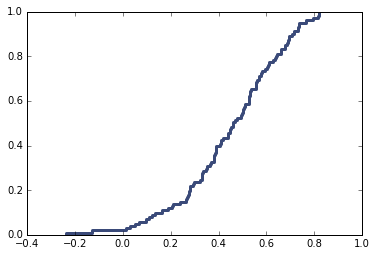

In [56]:
cdf4 = thinkbayes2.Cdf(dists[:, 4])
thinkplot.Cdfs([cdf4])

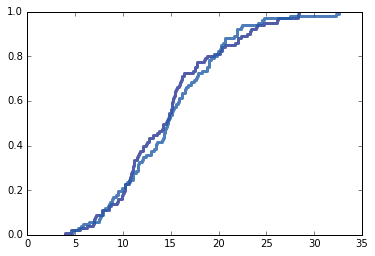

In [57]:
cdf5 = thinkbayes2.Cdf(dists[:, 5])
cdf6 = thinkbayes2.Cdf(dists[:, 6])
thinkplot.Cdfs([cdf5, cdf6])

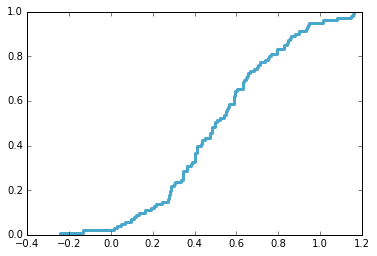

In [58]:
cdf7 = thinkbayes2.Cdf(dists[:, 7])
thinkplot.Cdfs([cdf7])

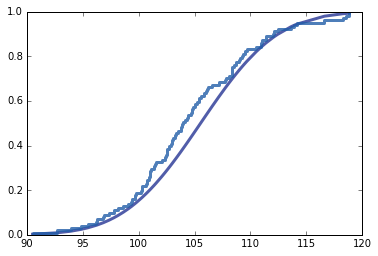

In [51]:
def sampling_dist_mean(i, mean, cov, cdf):
    sampling_dist = scipy.stats.norm(loc=mean[i], scale=np.sqrt(cov[i, i]/n))
    xs = cdf.xs
    ys = sampling_dist.cdf(xs)
    thinkplot.plot(xs, ys)
    thinkplot.Cdf(cdf)
    
sampling_dist_mean(0, mean, cov, cdf0)

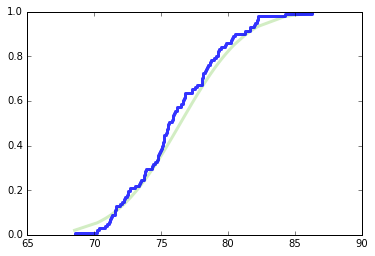

In [35]:
sampling_dist_mean(1, mean, cov, cdf1)

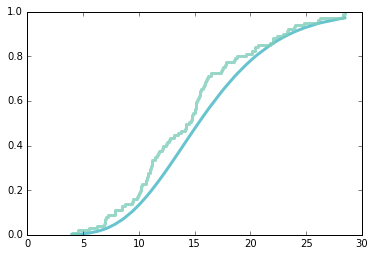

In [34]:
def sampling_dist_std(i, mean, cov, cdf):
    sampling_dist = scipy.stats.chi2(df=n)
    xs = cdf.xs
    ys = sampling_dist.cdf(xs)
    thinkplot.plot(xs, ys)
    thinkplot.Cdf(cdf)
    
sampling_dist_std(5, mean, cov, cdf5)

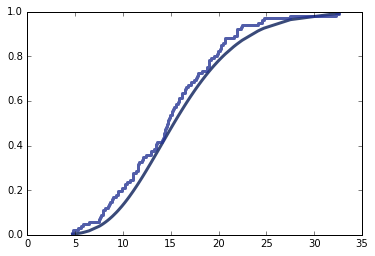

In [36]:
sampling_dist_std(6, mean, cov, cdf6)

0.524654930886


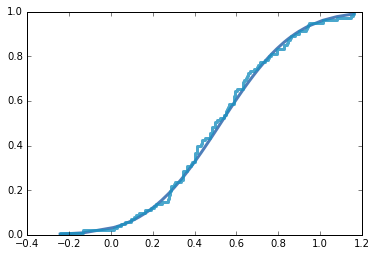

In [65]:
def sampling_dist_r(i, mean, cov, cdf):
    _, _, rho = std_rho(cov)
    sampling_dist = scipy.stats.norm(loc=z_prime(rho), scale=1/np.sqrt(n-3))
    xs = cdf.xs
    ys = sampling_dist.cdf(xs)
    thinkplot.plot(xs, ys)
    thinkplot.Cdf(cdf)
    
sampling_dist_r(7, mean, cov, cdf7)

In [40]:
pdf_X = scipy.stats.multivariate_normal(mean, cov/n)

In [41]:
pdf_X.pdf(mean)

0.0086661766965738761

In [42]:
pdf_S = scipy.stats.wishart(n, cov)

In [45]:
pdf_S.pdf(cov * (n-1))

2.1419690897181658e-11